In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def loadfile(mean, var, zmean, zvar, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res"):
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model, mean, zmean, 50, tau, int(mixtures), int(temp), s, data_size) + fn
    if (file=='res'):
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='gmp'):
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
    return file

### 1. Accuracy - Loss - Free Parameters

In [24]:
res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files")

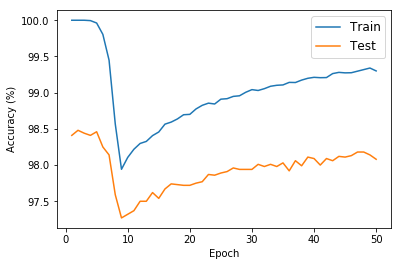

In [5]:
train = plt.plot(res['epochs'], res['train_acc'], label = "Train")
test = plt.plot(res['epochs'], res['test_acc'], label = "Test")
plt.legend(ncol=1, fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

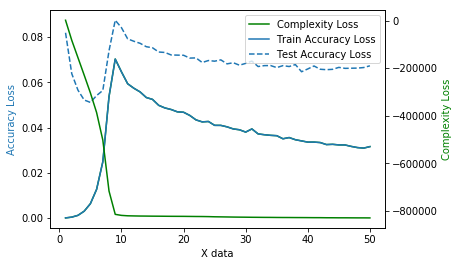

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Complexity Loss", color = 'g')
p = ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Train Accuracy Loss")
color = p[0].get_color()
ax1.plot(res['epochs'], res['test_loss'], label = "Test Accuracy Loss", linestyle = "--", color = color)
ax1.legend(loc=1)
ax2.plot(res['epochs'], res['complexity_loss'], label = "Complexity", color = 'g')

ax1.set_xlabel('X data')
ax1.set_ylabel('Accuracy Loss', color=color)
ax2.set_ylabel('Complexity Loss', color='g')
plt.show()

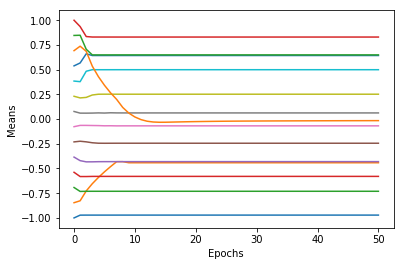

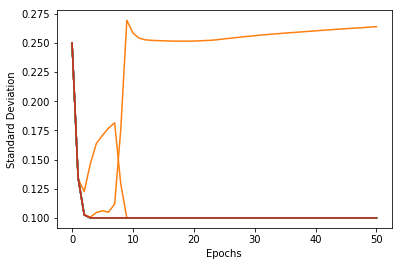

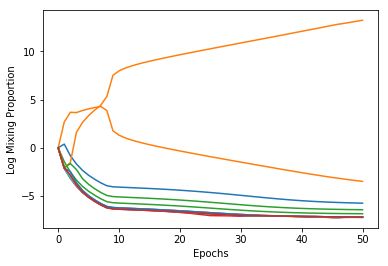

In [7]:
plt.plot([0] + res['epochs'], res['gmp_means'])
plt.xlabel('Epochs')
plt.ylabel('Means')
plt.show()

plt.plot([0] + res['epochs'], res['gmp_stddev'][:,1:]) #w/out 0 means
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()

plt.plot([0] + res['epochs'], np.log(res['gmp_mixprop']))
plt.xlabel('Epochs')
plt.ylabel('Log Mixing Proportion')
plt.show()

array([0.00387773, 0.10005003, 0.10005003, 0.10005003, 0.10005003,
       0.10005003, 0.10005003, 0.10005003, 0.10005003, 0.10005003,
       0.10005003, 0.10005003, 0.26379198, 0.10005003, 0.10005003],
      dtype=float32)

(0.01, 100.0)

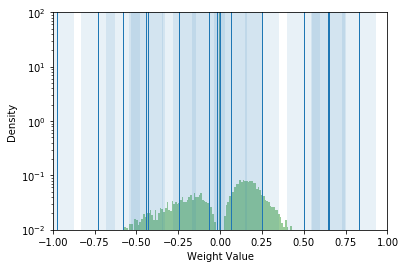

In [44]:
def stack_weights(weight_dict):
    weights = np.array([], dtype=np.float32)
    for layer in weight_dict:
        weights = np.hstack( (weights, weight_dict[layer] ) )
    return weights

weights = stack_weights(res['final_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.axvline(0, linewidth = 1)
std_dev0 = res['gmp_stddev'][-1][0]
plt.axvspan(xmin=-std_dev0, xmax=std_dev0, alpha=0.3)
for mean, std_dev in zip(res['gmp_means'][-1], res['gmp_stddev'][-1][1:]):
    plt.axvline(mean, linewidth = 1)
    plt.axvspan(xmin=mean - std_dev, xmax=mean + std_dev, alpha=0.1)
    
plt.xlabel("Weight Value")
plt.ylabel("Density")
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])

(0.01, 100.0)

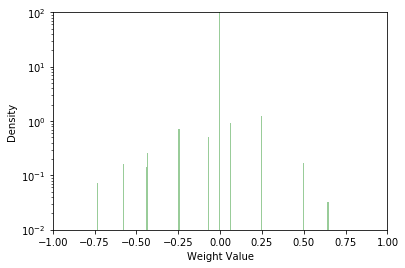

In [45]:
weights = stack_weights(res['prune_weights'])
sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})

plt.xlabel("Weight Value")
plt.ylabel("Density")
plt.xlim([-1, 1])
plt.ylim([1e-2, 1e2])

### 2. Variance on Gamma Priors

In [9]:
exp = pd.DataFrame(columns = ["var", "zvar", "acc", "sp"])
idx=0
start_processing = False
#start from 10, 1000
for var in [0.1, 1, 10, 100, 1000]:
    for zvar in [0.1, 1, 10, 100, 1000, 10000]:
        fn_text = "_var_{}_zvar_{}".format(var,zvar)
        res = loadfile(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", model_save_dir = "./files", fn=fn_text)
        exp.loc[idx] = ([var, zvar, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

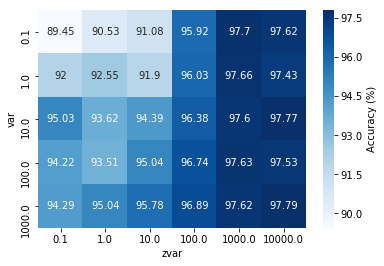

In [10]:
sns.heatmap(exp.pivot(index='var', columns='zvar', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt="g")

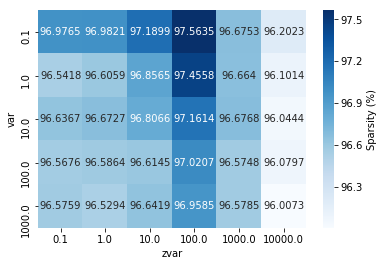

In [11]:
sns.heatmap(exp.pivot(index='var', columns='zvar', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt="g")

### 3. Means on Gamma Priors

In [21]:
m_exp = pd.DataFrame(columns = ["mean", "zmean", "acc", "sp"])
idx=0
#start from 10, 1000
for mean in [0.1, 1, 10, 100, 1000, 10000]:
    for zmean in [0.1, 1, 10, 100, 1000, 10000]:
        res = loadfile(mean, 0.1, zmean, 1000, 1e-6, int(0), 16, "LeNet_300_100", model_save_dir = "./files")
        m_exp.loc[idx] = ([mean, zmean, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

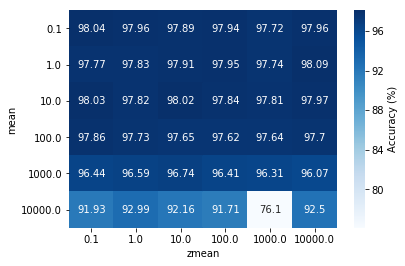

In [22]:
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt="g")

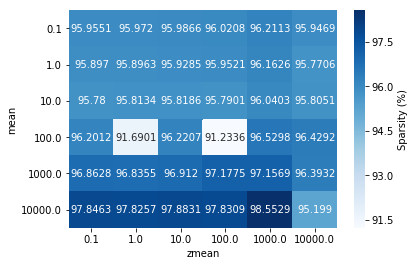

In [23]:
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt="g")